# (실습) PCA를 이용한 차원축소와 시각화

## 실습 개요

1) **실습 목적**

이번 실습에서는 고차원 데이터가 가진 정보를 최대한 보존하면서 저차원으로 표현하는 방법인 차원축소를 실습합니다. 먼저, 차원축소 방법론의 가장 대표적인 예시인 PCA(Principal Component Analysis)와 그 이론적 기반인 SVD(Singular Vector Decomposition) 행렬분해에 대해 학습합니다. 그 이후, t-SNE(t-distributed Stochastic Neighbor Embedding)를 사용해 고차원 데이터를 2차원 평면에 시각화해봅니다.

2) **수강 목표**

- SVD(Singular Vector Decomposition) 행렬분해의 결과로 나오는 행렬들이 각각 어떤 특성을 가지는지 이해한다.
- PCA(Principal Component Analysis) 이용해 차원축소를 수행할 수 있다.

- t-SNE(t-distributed Stochastic Neighbor Embedding)를 사용해 고차원 데이터를 2차원에 시각화할 수 있다.


### 실습 목차
* 1. SVD(Singular Vector Decomposition) 행렬분해의 특성과 활용
  * 1-1. SVD 구현을 위한 이론
  * 1-2. SVD 구현을 위한 보조함수 정의
  * 1-3. SVD 구현 실습
  * 1-4. SVD 행렬분해 결과의 특성
* 2. Truncated SVD를 통한 행렬의 rank 축소
* 3. PCA 구현 실습: EigenFace
* 4. t-SNE를 이용한 데이터셋 시각화
  - 4-1. 데이터 불러오기
  - 4-2. 데이터 시각화

### 환경 설정

- 패키지 설치 및 임포트

In [44]:
# 패키지 불러오기
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
# 시각화를 위한 패키지 불러오기
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import offsetbox

## 1. SVD(Singular Vector Decomposition) 행렬분해의 특성과 활용

```
💡 목차 개요 : SVD(Singular Vector Decomposition) 행렬분해의 결과 행렬들이 어떤 특성을
가지는지 이해한다.
```

- 1-1. SVD 구현을 위한 이론
- 1-2. SVD 구현을 위한 보조함수 정의
- 1-3. SVD 구현 실습
- 1-4. SVD 행렬분해 결과의 특성

### 1-1. SVD 구현을 위한 이론
> SVD행렬분해의 정의에 대해 설명합니다.

#### 📝 설명: SVD (Singular Vector Decomposition) 란?
특이값 행렬분해, SVD란 행렬 $M \in{\mathbb{R}^{m \times n}}$를 다음과 같이 특별한 성질을
가진 3개의 행렬들의 곱으로 나타내는 과정을 말합니다.

$M=U\Sigma V^T$.

여기서 3개의 행렬 U, $\Sigma$, V는 각각
1. $U$는 m차원 정규 직교 행렬 (orthonormal matrix)
2. $\Sigma$(sigma)는 singular value를 성분으로 하는 대각 행렬(diagonal matrix)
3. $V$는 n차원 정규 직교 행렬 (orthonormal matrix)

이라는 특성이 있습니다.



### 1-2. SVD 구현을 위한 보조함수 정의
> 본격적인 내용 설명에 앞서, 행렬은 그 크기가 커질수록 단순히 print했을 때 보기 매우 불편해지기 때문에 시각화를 위한 보조함수를 정의해봅니다.


#### 👨‍💻 코드 : 행렬의 시각화를 위한 보조함수
- 행렬 시각화를 위한 보조함수 `plot_matrix` 정의
- 랜덤 데이터행렬을 생성한 뒤 `plot_matrix`함수를 통해 시각화

In [46]:
# 행렬 시각화를 위한 보조함수 정의
def plot_matrix(matrix, numbers=True, size_scale=0.7):
    """
    matrix로 주어진 행렬을, 보기쉽게 그려주는 함수입니다.
    행렬의 크기가 큰 경우 numbers를 False로 설정해 각 원소의 값이 표시되지 않도록 하고,
    size_scale을 줄여 전체 크기를 조절할 수 있습니다.
    """
    n_rows, n_cols = matrix.shape
    # 행렬 크기에 비례하도록 figure의 사이즈 설정
    figure_size = (size_scale * n_cols, size_scale * n_rows)
    fig, ax = plt.subplots(figsize=figure_size)
    # 불필요한 부분들 비활성화
    viz_args = dict(cmap='Purples', cbar=False, xticklabels=False, yticklabels=False)
    sns.heatmap(data=matrix, annot=numbers, fmt='.2f', linewidths=.5, **viz_args)

In [49]:
# 실습파일을 여러번 실행해도 같은 결과가 나오도록 random seed를 고정합니다.
np.random.seed(1234)

# 6x9 크기의 랜덤 행렬을 생성합니다.
M = np.random.randn(6, 9)

# 단순 print을 이용하여 행렬 시각화
print(M)

[[ 4.71435164e-01 -1.19097569e+00  1.43270697e+00 -3.12651896e-01
  -7.20588733e-01  8.87162940e-01  8.59588414e-01 -6.36523504e-01
   1.56963721e-02]
 [-2.24268495e+00  1.15003572e+00  9.91946022e-01  9.53324128e-01
  -2.02125482e+00 -3.34077366e-01  2.11836468e-03  4.05453412e-01
   2.89091941e-01]
 [ 1.32115819e+00 -1.54690555e+00 -2.02646325e-01 -6.55969344e-01
   1.93421376e-01  5.53438911e-01  1.31815155e+00 -4.69305285e-01
   6.75554085e-01]
 [-1.81702723e+00 -1.83108540e-01  1.05896919e+00 -3.97840228e-01
   3.37437654e-01  1.04757857e+00  1.04593826e+00  8.63717292e-01
  -1.22091575e-01]
 [ 1.24712954e-01 -3.22794806e-01  8.41674713e-01  2.39096052e+00
   7.61995878e-02 -5.66445930e-01  3.61419367e-02 -2.07497760e+00
   2.47792200e-01]
 [-8.97156784e-01 -1.36794833e-01  1.82891913e-02  7.55413982e-01
   2.15268581e-01  8.41008795e-01 -1.44581008e+00 -1.40197328e+00
  -1.00918200e-01]]


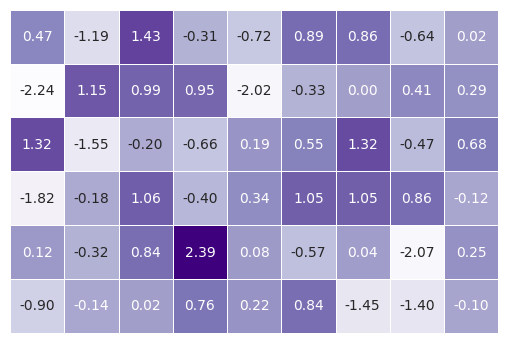

In [50]:
# 보조함수를 활용하여 행렬 시각화
plot_matrix(M)

### 1-3. SVD 구현 실습

> SVD를 구현합니다.

#### 📝 설명: 전체 SVD과정을 확인하기 위한 보조함수 정의

SVD는 numpy 라이브러리를 활용하여 수행하는데,
numpy에서 SVD를 수행해주는 이 함수(`np.linalg.svd`)는 대각행렬 sigma의 0인 부분을 생략하고 대각성분인 singular value들만 array형태로 리턴해주도록 구현되어있습니다.

실제로 사용할때는 훨씬 실용적인 방식이기는 하지만, 강의에서는 이론상 정확한 설명을 위해
완전한 대각행렬을 반환해주는 새로운 함수 `full_svd`를 정의해
사용하겠습니다.


#### 👨‍💻 코드 : 보조함수 정의
- 전체 SVD과정 확인을 위한 보조함수 `full_svd` 정의
- 이를 이용해 랜덤 행렬에 svd적용

In [5]:
def full_svd(matrix):
    # numpy를 이용한 SVD를 수행합니다.
    U, singular_values, V = np.linalg.svd(matrix)

    # numpy의 svd 결과로 나오는 sigma의 diagonal 성분을 가지고 diagonal matrix를 복원해줍니다.
    m, n = matrix.shape       # matrix 행렬의 차원
    sigma = np.zeros([m, n])  # matrix 행렬과 같은 차원의 영행렬을 만들어둡니다.

    rank = len(singular_values)  # rank 계산
    sigma[:rank, :rank] = np.diag(singular_values)  # rank까지만 복원
    return U, sigma, V.T

In [6]:
# SVD 수행
U, Sigma, V = full_svd(M)


#### 👨‍💻 코드 : SVD결과로부터 원본 행렬 복원
- 분해 결과 행렬을 통해 원본 행렬이 복원되는지 확인

Maximum diff:  2.6645352591003757e-15


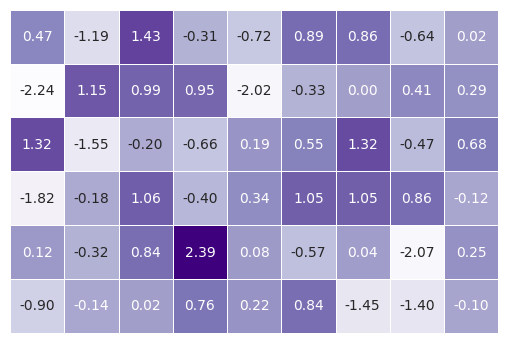

In [7]:
# 파이썬의 @ 연산자를 이용하면 np.dot 함수와 같은 행렬곱이나 내적을 편리하게 호출할 수 있습니다.
restored = U @ Sigma @ V.T # T는 전치행렬(transpose)

# 행렬 시각화
plot_matrix(restored)
print("Maximum diff: ", np.abs(M - restored).max())

#### 📝 설명: Truncation Error
복구된 행렬과 원래 행렬 사이 오차의 최대값이 사실상 0이라고 볼수 있는 `e-15`, 즉 $10^{-15}$ 정도의 스케일이므로 행렬분해가 문제없이 수행되었음을 알 수 있습니다.

참고로, 컴퓨터 내의 숫자표기는 메모리의 효율성을 위해 그 정밀도가 어느정도 제한되어 있기 때문에 이 정도
수준의 오차는 어쩔수 없이 항상 발생하게 됩니다. 이를 Truncation Error라고 부릅니다.




### 1-4. SVD 행렬분해 결과의 특성
> SVD 행렬분해 결과인 U, Sigma, V가 각각 어떤 특성을 가지는지 알아봅니다.

행렬 U, $\Sigma$, V는 각각 다음과같은 shape을 가지고 있어, 순서대로 곱했을 때 원래의 행렬과 같은 크기가 됩니다.


In [8]:
# U, Sigma, V의 shape 확인
print(U.shape, Sigma.shape, V.shape)

(6, 6) (6, 9) (9, 9)


#### 📝 설명 : 정규직교행렬(orthonormal matrix) U, V
행렬 U와 V는 모두 선형대수학에서 정규직교행렬(orthonormal matrix)이라고 부르는 행렬입니다.
이 행렬은 시각화 결과에서 보이듯이 육안으로 눈에 띄는 특성이 있는것은 아니지만, 각 행을 별개의 벡터로 볼때 모두가 서로 직교하고, 길이(norm)가 1인 행렬로 정의됩니다.

이런 정의로 인해 정규직교행렬은 자기자신의 transpose와 곱했을 때 단위행렬이 나온다는, 즉
단순히 transpose만 해주면 역행렬이 된다는 편리한 특성을 지닙니다.


#### 👨‍💻 코드 : U, V의 정규직교행렬로서의 특성 확인
- 정규직교행렬의 정의에 따른 특성 확인
- 역행렬과 곱해서 단위행렬이 나오는것 확인

다음 두 셀은 V에 대해 수행해도, 행렬의 크기만 다를 뿐 같은 결과를 확인할 수 있습니다.

-5.412337245047638e-16
1.0000000000000009


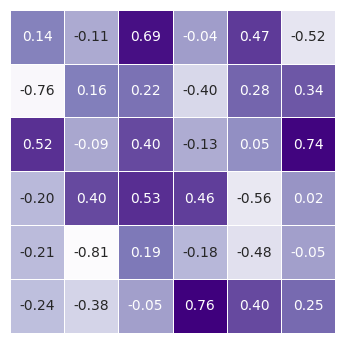

In [9]:
# 행렬 U를 시각화
plot_matrix(U)

# 행렬의 서로 다른 row를 골라 내적하면 0이 나옵니다.
print(U[1] @ U[3])

# 자기 자신과의 내적(벡터의 norm, 길이라고 생각할수 있는 개념)은 항상 1이 나옵니다.
print(U[1] @ U[1])

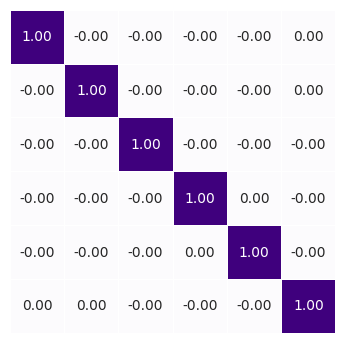

In [10]:
# U @ U.T 행렬 시각화
plot_matrix(U @ U.T)

이제, $\Sigma$의 특성을 확인해보겠습니다.

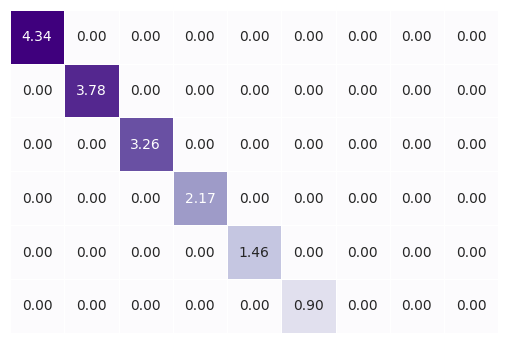

In [11]:
# Sigma 행렬 시각화
plot_matrix(Sigma)

$\Sigma$는 singular value를 대각성분으로 하는 대각행렬이며, SVD의 결과에서 이 대각선 성분은
보시다시피 뒤로 갈수록 값이 작아지도록 정렬되어있습니다. singular value는 행렬의 eigen value와
관련된 개념으로, 이와 관련되어서 SVD의 수많은 흥미로운 특성들을 유도해낼 수 있지만, 여기에서는 생략하고, 다음의 특성에 주목해보겠습니다.

행렬 $\Sigma$에서 단 한개, k번째의 값만 남기고 나머지를 전부 0으로 만든 $\Sigma_k$라는 행렬을 생각해보겠습니다.

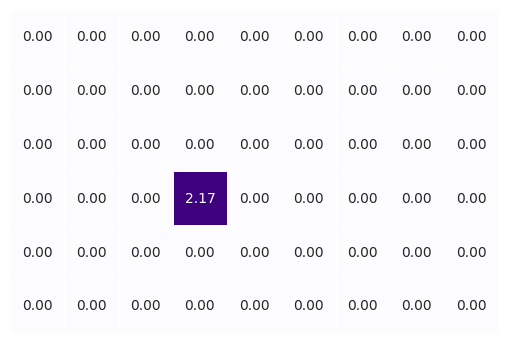

In [12]:
# 행렬의 (k,k)번째 원소만 남기고 나머지를 0으로 만드는 함수 정의
def select_diag(sigma, k):
    result = np.zeros_like(sigma)  # 영행렬 만들어두기
    result[k, k] = sigma[k, k]  # sigma 행렬의 (k,k) 원소만 남김
    return result

# Sigma의 (k,k)번째 원소만 남기고 나머지를 0으로 만들기
sigma_k = select_diag(Sigma, 3)
# 결과 행렬 시각화
plot_matrix(sigma_k)

행렬 M이 r개의 singular value를 가진다고 할 때

$\Sigma = \Sigma_0 + \Sigma_1 + ... \Sigma_r$이므로, 위의 SVD식을 다음과 같이 적을 수 있으며:

$M=U\Sigma V^T = U\Sigma_0V^T + U\Sigma_1V^T + ... U\Sigma_rV^T$,

이 식을 코드로는 다음과 같이 확인해볼 수 있습니다.

Maximum diff:  3.1086244689504383e-15


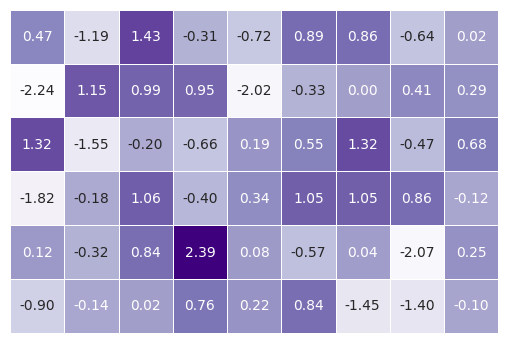

In [13]:
# 원래 행렬의 rank
r = np.linalg.matrix_rank(M)

# 결과 행렬을 미리 initialize
result = np.zeros_like(M)
for k in range(r):
    # Sigma_k를 계산 후 결과행렬에 더해줌.
    sigma_k = select_diag(Sigma, k)
    result += U @ sigma_k @ V.T

# 결과 행렬과 원래 행렬의 차이를 계산
print("Maximum diff: ", np.abs(M - result).max())
# 결과 행렬 시각화
plot_matrix(result)

그런데, $\Sigma_k$는 결국 (k, k) 원소만 0이 아닌 행렬이므로, 다음과 같이 U와 V의 k번째 열벡터
하나씩만 가지고도 계산하더라도 완전히 동일한 결과를 얻을 수 있습니다.

Maximum diff:  3.1086244689504383e-15


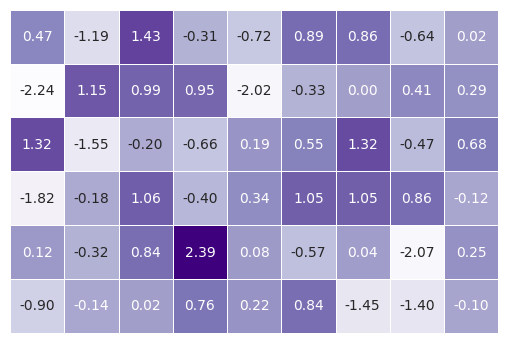

In [14]:
# k번째 열벡터를 가져오는 함수를 정의
def col_vec(matrix, k):
    return matrix[:, [k]]

# 원래 행렬의 rank
r = np.linalg.matrix_rank(M)

# 결과 행렬을 미리 initialize
result = np.zeros_like(M)
for k in range(r):
    # k번째 singular value, 스칼라값
    sig_k = Sigma[k, k]
    # U, V에서 한개의 column vector만을 가져와 사용해도 위 셀과 동일한 결과
    result += sig_k * col_vec(U, k) @ col_vec(V, k).T

# 결과 행렬과 원래 행렬의 차이를 계산
print("Maximum diff: ", np.abs(M - result).max())
# 결과 행렬 시각화
plot_matrix(result)

여기에서 각 단계에 더해진 행렬들처럼, 두 벡터의 곱으로 표현되는 행렬은 선형대수학에서 rank-1
matrix라고 부르는 개념으로,
크기는 행렬이지만 가지고있는 정보량은 곱해지는 벡터 두개와 동일하다는 특성을 가지며,
행렬을 만드는 기본단위처럼 사용되는 개념입니다.

(6, 1)
(1, 9)
(6, 9)
Rank of resulting Rank-1 Matrix:  1


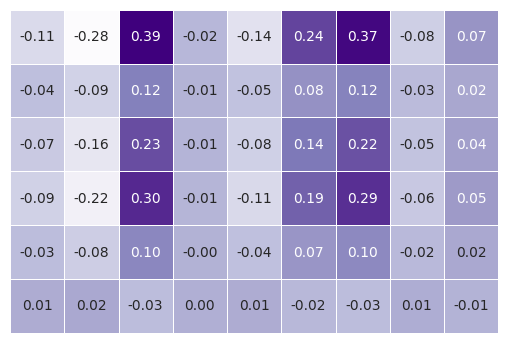

In [15]:
# 임의의 k를 선택합니다.
k = 2
# 곱해지는 U, V의 열벡터를 표시합니다.
print(col_vec(U, k).shape)
print(col_vec(V, k).T.shape)

# 두 벡터의 행렬곱으로 rank-1 matrix를 만듭니다.
rank1_mat = col_vec(U, k) @ col_vec(V, k).T

print(rank1_mat.shape)

# 이름처럼 rank는 1로 나옵니다.
print("Rank of resulting Rank-1 Matrix: ", np.linalg.matrix_rank(rank1_mat))

# matrix의 값들을 살펴보면, 첫번째 row에 스칼라곱을 해서 나머지 모든
# row를 만들수 있고(linearly dependence), 이는 column도 마찬가지입니다.
plot_matrix(rank1_mat)

## 2. Truncated SVD를 통한 행렬의 rank 축소

#### 📝 설명: Truncated SVD를 통한 행렬의 rank 축소

위에서는 rank가 r인(r개의 singular value를 가지는) 행렬 M이 있을 때,
SVD를 활용하면 이를 r개의 rank1 matrix들의 합으로 표현할 수 있다는 것을 알아보았습니다.
Truncated SVD란 이를 활용해, r개의 성분들 중 크기가 작은 것들을 버리고 행렬 M을 낮은 rank의 행렬로 나타내는 차원축소 방법론이라고 이해할 수 있습니다.

먼저, 위에 작성했던 코드를 살짝 수정해, Truncated SVD를 통한 차원축소를 수행하는 함수를 정의해보겠습니다.

In [16]:
def reduce_dim(M, n_components=None):
    # 주어진 행렬 M을 SVD합니다.
    U, Sigma, V = full_svd(M)

    r = np.linalg.matrix_rank(M)
    if n_components is None:
        # 몇개의 성분을 남길지 주어지지 않으면 아무것도 버리지 않고 전체 성분을 남깁니다.
        n_components = r

    # 남길 component 수가 전체 랭크보다 크면 에러 메시지 보여줍니다.
    assert n_components <= r, \
        f"남길 component의 개수({n_components})는 전체 랭크{r}보다 클 수 없습니다."

    # 결과 행렬을 미리 initialize
    result = np.zeros_like(M, dtype=np.float64)
    # 이번에는 r개가 아니라, 첫 n_components개까지만 rank-1 matrix들을 더해줍니다.
    for k in range(n_components):
        # k번째 singular value, 스칼라값과
        sig_k = Sigma[k, k]
        # rank1 행렬에 위 sig_k 스칼라값을 곱해 결과에 더함.
        result += sig_k * col_vec(U, k) @ col_vec(V, k).T
    return result

이제 다음 셀에서 truncated_svd를 통해 첫 k개의 성분만 남긴 행렬과 원래 행렬을 비교해볼 수 있습니다.

In [17]:
# 남길 성분의 수. 이 값을 0~6까지 직접 값을 조절해볼수 있습니다.
n_components = 5
size_scale = 0.6 # 비교해보기 편하도록 figure크기를 살짝 줄입니다.

# 원래 행렬의 rank를 구해봅니다.
print("Original rank: ", np.linalg.matrix_rank(M))

# TruncatedSVD를 수행해 n_component개의 성분만 남깁니다.
result = reduce_dim(M, n_components)

# TruncatedSVD 결과 행렬의 rank와 원본 행렬과의 값 차이를 프린트합니다.
print("Result rank: ", np.linalg.matrix_rank(result))
print("Maximum diff: ", np.abs(M - result).max())

Original rank:  6
Result rank:  5
Maximum diff:  0.4306720751871564


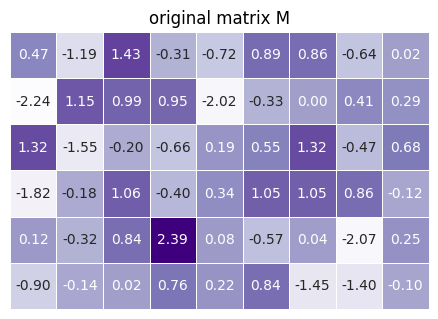

In [18]:
# 원래의 행렬
plot_matrix(M, size_scale=size_scale)
plt.title('original matrix M')  # 구분을 위해 시각화 제목 넣기
plt.show()                      # 그림 보여주기

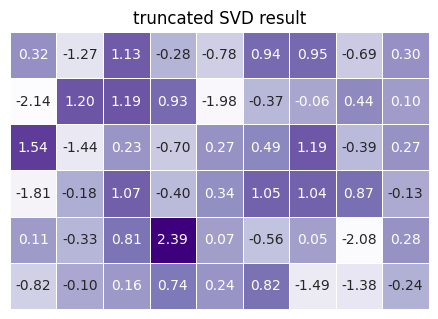

In [19]:
# truncated svd 결과 행렬
plot_matrix(result, size_scale=size_scale)
plt.title('truncated SVD result')  # 구분을 위해 시각화 제목 넣기
plt.show()               # 그림 보여주기

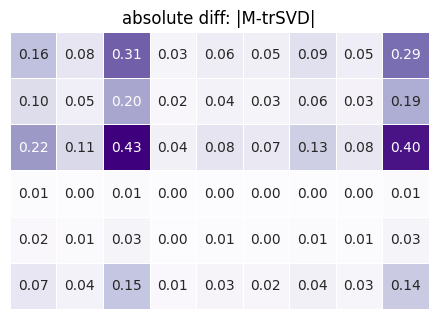

In [20]:
# 원래 행렬과의 차이(absolute diff)
plot_matrix(np.abs(M - result), size_scale=size_scale)
plt.title('absolute diff: |M-trSVD|')  # 구분을 위해 시각화 제목 넣기
plt.show()                  # 그림 보여주기

## 3. PCA 구현 실습: EigenFace

```
💡 목차 개요 : PCA(Principal Component Analysis) 이용해 차원축소를 수행할 수 있다.
```


#### 📝 설명: EigenFace

EigenFace는 1990년대 연구되었던 얼굴인식(Face Recognition)을 위한 방법론으로, PCA를
이용해 사람의 얼굴 이미지를 저차원의 벡터로 표현하고, 이를 서로 비교해 같은 사람인지 아닌지 판단하는 방식으로 작동합니다. 여기서는 The Olivetti faces 데이터셋 ([링크](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html))을
가져와, Eigen Face의 차원축소가 어떻게 작동하는지 실습해봅니다.

#### 📚 자료

*  [Faces dataset decompositions](https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py) : scikit
learn에서 제공하는 공식 튜토리얼 문서로, 이 실습코드에서 Olivetti faces 데이터셋의 처리와 시각화
부분은 해당 문서의 코드를 참고하여 작성했습니다. 이 실습코드가 PCA라는 한가지 방법론의 원리를
설명하는데에 집중했다면, 위 문서에서는 같은 데이터에 다양한 방식의 차원축소를 적용해 어떤 차이가 나타나는지 예시를 확인해볼 수 있습니다.


In [21]:
# 데이터 불러오기
faces, _ = datasets.fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=1234)

n_samples, n_features = faces.shape
print('데이터 수:', n_samples) # 데이터 수 확인
print('차원 수:', n_features) # 차원수 확인

데이터 수: 400
차원 수: 4096


In [22]:
# 첫번째 데이터 확인하기
faces[0, :]

array([0.5082645 , 0.5082645 , 0.5082645 , ..., 0.60330576, 0.59504133,
       0.59917355], shape=(4096,), dtype=float32)

데이터를 불러오면 위와같이 일반적인 0~255값(uint8타입)의 이미지들이 아니라  
400x4096의 커다란 float타입 행렬이 불러와집니다. 이는 이 데이터셋이 이미지를 미리 가공된 상태로
제공하기 때문인데, 400장의 이미지 각각을 flatten하여 vector로 만들고, 이를 row vector로 하는
행렬로 만든것입니다.

In [23]:
# 데이터 범위 확인하기
print('평균:', faces.mean())
print('최댓값:', faces.max())
print('최솟값:', faces.min())

평균: 0.5470425
최댓값: 1.0
최솟값: 0.0


데이터의 각 값들은 0에서 1 사이의 값을 가집니다.



이 데이터를 우리가 알아볼 수 있는 이미지의 형태로 확인하려면 별도의 변환 과정을 거쳐야 하는데,
한번 400개중 하나의 이미지를 선택해서, 이미지로 변환해보겠습니다.

105-th row of matrix


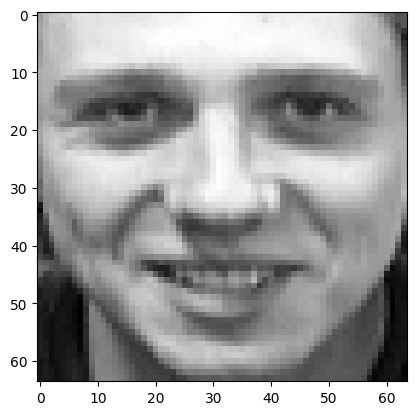

In [24]:
# 가져올 샘플의 번호를 랜덤으로 고름
index = np.random.choice(len(faces))
print(f"{index}-th row of matrix")

# 원본 이미지의 크기
img_h, img_w = (64, 64)

# 데이터(faces)에서 샘플(row)을 선택해 가져오기
face_vector = faces[index]

# 이미지를 원래의 크기로 변환한 후 display
face_image = face_vector.reshape(img_h, img_w)
plt.imshow(face_image, cmap="gray")

지금은 matplotlib의 `imshow`함수가 **0\~1 범위의 float 숫자**도 이미지로 쉽게 변환해볼 수 있는 기능을 지원하기 때문에, 값의 범위를 **0\~255 범위의 픽셀값(int)**으로 변환하는 작업은 하지 않아도 괜찮습니다.
하지만 PCA분석을 위해서는 다음 각 데이터의 feature-wise, sample-wise로 평균이 모두 0이
되어야하므로 이에 맞춰 다음과 같이 전처리를 수행해준 이후에는 별도의 scaling 과정을 거쳐야 제대로
이미지를 확인할 수 있습니다.

In [25]:
# 전체 샘플단위의 평균을 구하고, 이를 원본 데이터에서 빼서 평균을 0으로 맞춰줌
samplewise_mean = faces.mean(axis=0) # (4096, )
faces_centered = faces - samplewise_mean

# 각 이미지마다 모든 픽셀값의 평균을 구하고, 이를 원본 이미지에서 빼는 방식으로 평균을 0으로 맞춰줌
pixelwise_mean = faces_centered.mean(axis=1).reshape(n_samples, -1) # (400, )
faces_centered -= pixelwise_mean

In [26]:
# 시각화를 위한 함수 정의하기
def plot_faces(title, images, n_cols=3, n_rows=2, shuffle=False, cmap="gray", size_scale=2.0, random_seed=0, image_shape=(64, 64)):
    # plot할 이미지(벡터)들을 랜덤으로 선택
    if shuffle:
        np.random.seed(random_seed)
        indices = np.random.choice(len(images), n_cols * n_rows)
    else:
        indices = np.arange(n_cols * n_rows)

    # figure관련 설정
    fig, axs = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(n_cols * size_scale, n_rows * size_scale),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)

    # 각 자리에 들어가는 얼굴 이미지를 plot
    for ax, idx in zip(axs.flat, indices):
        face_vec = images[idx]
        vmax = max(face_vec.max(), - face_vec.min())
        im = ax.imshow(
            face_vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")
    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

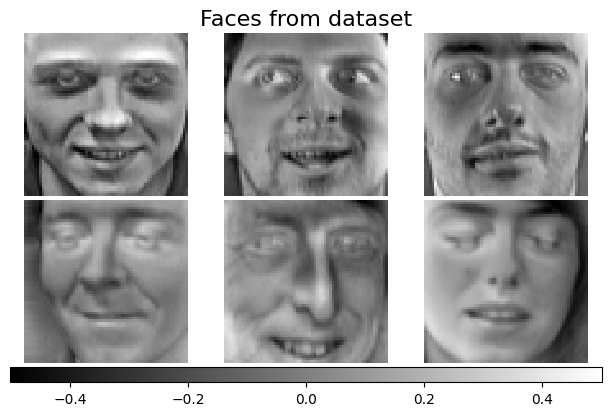

In [27]:
# 이미지 6개 시각화하기
plot_faces("Faces from dataset", faces_centered, shuffle=True, random_seed=1234)

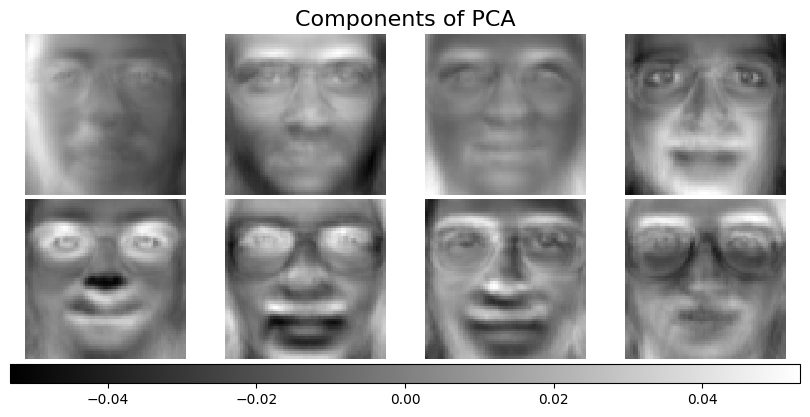

In [28]:
# 줄일 차원의 수 지정하기
n_components = 20

# PCA 수행하기
pca_estimator = PCA(n_components=n_components, svd_solver="full", whiten=True)
pca_estimator.fit(faces_centered)

# PCA 결과 (Eigenface) 시각화
plot_faces("Components of PCA", pca_estimator.components_, n_rows=2, n_cols=4)

위에서 방금 수행한 작업은 400개의 얼굴 이미지들을 서로 구분하는데 가장 유의미한 첫 8개의
components들을 다시 이미지의 형태로 시각화한것입니다.

이를 이해하기 위해 400개의 이미지들 중 하나를 골라 차원축소된 벡터와 components로 원본 이미지를 복원해보도록 하겠습니다.

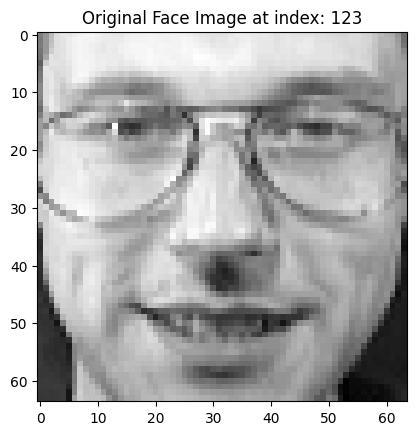

In [29]:
# 원본 이미지중에 임의로 하나를 고릅니다.
index = 123
indices = np.random.choice(n_samples, 6)
# 원본 이미지를 보여줍니다.
plt.title(f"Original Face Image at index: {index}")
plt.imshow(faces[index].reshape(64, 64), cmap="gray")

이 이미지는 원래의 4096(64*64)차원에서, PCA estimator를 통해 차원축소되어 다음과 같은 `n_components` 차원 벡터로 표현됩니다.

In [30]:
# 차원축소된 벡터 계산하기
reduced_vec = pca_estimator.transform(faces_centered[index].reshape(1, -1))
print(reduced_vec)
print('차원 축소된 벡터의 크기:', reduced_vec.shape)

[[ 0.940876    0.14279033 -1.5851119  -0.17483647 -1.2675631   0.3187973
   0.7201098   1.645985    0.38829848 -1.4495773   0.18704636  0.7542883
   0.28385264  1.7160143   1.5398421   0.9073749   0.15089071  0.8248284
  -0.5109379  -0.7519169 ]]
차원 축소된 벡터의 크기: (1, 20)


fitting 된 PCA의 component들을, 위 reduced_vec의 원소를 계수로 하는 선형결합하면,
다음과 같이 원본 이미지를 복원할 수 있습니다.

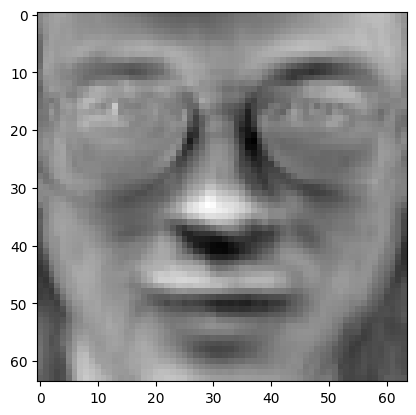

In [31]:
# 결과 행렬 미리 initialize
canvas = np.zeros([64, 64], dtype=np.float64)
for value, comp in zip(reduced_vec[0], pca_estimator.components_):
    # 각 component 벡터를 이미지 크기로 resize한 뒤, 이를 차원축소된 벡터의 각 값과 선형결합
    canvas += comp.reshape(64, 64) * value

vmax = max(canvas.max(), - canvas.min())

plt.imshow(canvas, cmap="gray", vmax=vmax, vmin=-vmax)

지금은 축소된 차원의 수, `n_components`가 너무 작아 복원된 이미지가 원본과 같은 이미지라는 것은
겨우 알아볼 수 있을 정도지만, 원본 이미지의 디테일한 부분들은 상당히 소실된 상태입니다.
`n_components` 값에 따라 차원축소된 이미지가 어떤 형태로 나타나는지 아래에서 비교해봅니다.

In [32]:
# 원본 이미지와 차원축소된 이미지들 비교하기
def compare_reduced_faces(title, images, index=123, n_components_list=[5, 20, 100], n_cols=4, n_rows=1, shuffle=False, cmap="gray", size_scale=2.5, random_seed=0, image_shape=(64, 64)):
    # 그림 관련 설정
    fig, axs = plt.subplots(
        nrows=n_rows, ncols=n_cols,
        figsize=(n_cols * size_scale, n_rows * size_scale),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")

    # 보여줄 이미지 선정
    face_vec = faces[index]

    # 첫 이미지로 원본 이미지를 보여줍니다.
    axs[0].set_title("Original Face Image", y=-0.2)
    axs[0].imshow(face_vec.reshape(image_shape), cmap="gray")
    axs[0].axis("off")

    # 다음 이미지부터는 PCA를 이용해 차원축소된 이미지를 보여줍니다.
    # 각 차원마다 보여주므로 줄일 차원의 수 리스트 중 하나씩 지정하여 PCA를 수행합니다.
    for img_index, n_components in enumerate(n_components_list):

        # PCA 수행하기
        pca_estimator = PCA(n_components=n_components, svd_solver="full", whiten=True)
        pca_estimator.fit(images)

        # 차원축소된 벡터 계산하기
        reduced_vec = pca_estimator.transform(face_vec.reshape(1, -1))
        # 결과 행렬 미리 initialize
        canvas = np.zeros([64, 64], dtype=np.float64)
        for value, comp in zip(reduced_vec[0], pca_estimator.components_):
            # 각 component 벡터를 이미지 크기로 resize한 뒤, 이를 차원축소된 벡터의 각 값과 선형결합
            canvas += comp.reshape(64, 64) * value

        # PCA 결과 (Eigenface) 시각화
        vmax = max(canvas.max(), - canvas.min())
        im = axs[img_index+1].imshow(
            canvas.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        axs[img_index+1].axis("off")
        axs[img_index+1].set_title(f'Dimension={n_components}', y=-0.2)

    # 최종 이미지 보여주기
    plt.suptitle(title + f': images at index {index}', fontsize=20)
    plt.show()

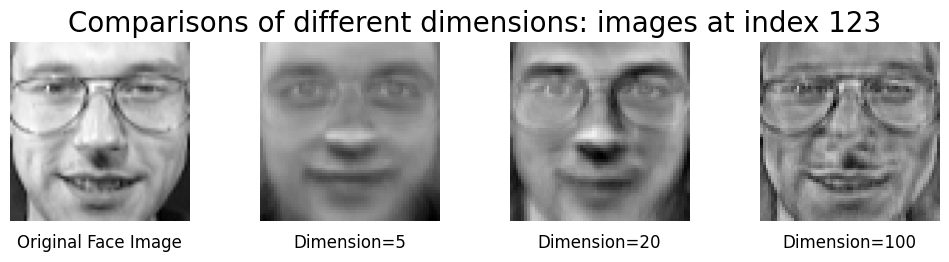

In [33]:
compare_reduced_faces('Comparisons of different dimensions', faces_centered, n_components_list=[5, 20, 100])

`n_components`가 5일 때, 즉 5차원으로 축소시키면 사람이라는 이미지는 인식할 수 있으나 원본 이미지에 나타난 사람과는 다소 차이가 있고 안경도 인식할 수 없습니다.
`n_components`가 100일 때는 원본 이미지의 여러 디테일한 정보들까지 함께 복원되었습니다.
이처럼 `n_components` 값을 늘리면 좀더 세세한 정보들까지 유지하면서 차원축소를 진행할 수 있지만, 대신 그만큼 차원 수가
덜 줄어드는 것이므로 어느정도 적당한 선에서 결정해야 합니다.

어느정도의 `n_components`의 값이 적절한지는 데이터가 가지고있는 정보량, 즉
얼마나 예측 가능한 정보인가에 따라 달라집니다. 예시를 위해 매우 높은 "정보량"을 가진 랜덤 행렬을 만들어
PCA로 피팅했을 때 위의 결과와 어떤 차이가 있는지 살펴보겠습니다.

방금의 PCA에 사용된 singular values, 즉 $\Sigma$의 대각 원소들은 다음과 같습니다. 이 값들은 각
성분, 즉 component가 이미지들을 서로 구분하는데 얼마나 중요한지를 나타내는데, 뒤로갈수록 빠르게 값이
작아지는 것, 즉 해당 성분이 이미지의 구분에 덜 중요하다는 것을 확인할 수 있습니다.

In [34]:
# singular value 확인하기
pca_estimator.singular_values_

array([67.12953 , 50.25966 , 41.992905, 37.271946, 31.780453, 28.802645,
       25.47032 , 25.33727 , 23.112808, 22.469482, 21.306623, 20.094738,
       19.481876, 18.365597, 17.79464 , 17.228045, 16.356886, 15.426776,
       15.386468, 14.981871], dtype=float32)

비교를 위해, 위의 얼굴 데이터와 크기, 모양이 같지만 값 자체는 그냥 랜덤정규분포에서 샘플링한 가짜 데이터
행렬을 만들어 PCA fitting을 수행해보겠습니다.

In [35]:
# 기존 faces데이터셋과 같은 크기의 랜덤 정규분포 데이터를 생성
random_noises = np.random.randn(*faces_centered.shape)

# 이 랜덤 포인트에 대해 PCA 수행하기
pca_estimator = PCA(n_components=n_components, svd_solver="full", whiten=True)
pca_estimator.fit(random_noises)

,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",20
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",True
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.linalg.svd` and select the components by postprocessing""covariance_eigh"" : Precompute the covariance matrix (on centered data), run a classical eigenvalue decomposition on the covariance matrix typically using LAPACK and select the components by postprocessing. This solver is very efficient for n_samples >> n_features and small n_features. It is, however, not tractable otherwise for large n_features (large memory footprint required to materialize the covariance matrix). Also note that compared to the ""full"" solver, this solver effectively doubles the condition number and is therefore less numerical stable (e.g. on input data with a large range of singular values).""arpack"" : Run SVD truncated to `n_components` calling ARPACK solver via `scipy.sparse.linalg.svds`. It requires strictly `0 < n_components < min(X.shape)`""randomized"" : Run randomized SVD by the method of Halko et al... versionadded:: 0.18.0.. versionchanged:: 1.5 Added the 'covariance_eigh' solver.",'full'
,"tol tol: float, default=0.0Tolerance for singular values computed by svd_solver == 'arpack'.Must be of range [0.0, infinity)... versionadded:: 0.18.0",0.0
,"iterated_power iterated_power: int or 'auto', default='auto'Number of iterations for the power method computed bysvd_solver == 'randomized'.Must be of range [0, infinity)... versionadded:: 0.18.0",'auto'
,"n_oversamples n_oversamples: int, default=10This parameter is only relevant when `svd_solver=""randomized""`.It corresponds to the additional number of random vectors to sample therange of `X` so as to ensure proper conditioning. See:func:`~sklearn.utils.extmath.randomized_svd` for more details... versionadded:: 1.1",10
,"power_iteration_normalizer power_iteration_normalizer: {'auto', 'QR', 'LU', 'none'}, default='auto'Power iteration normalizer for randomized SVD 

이 경우에는 singular value의 분포가 눈으로 보기에도 확연히 다른것을 알 수 있는데, 뒤로갈수록 크기가
확연히 줄어드는 얼굴데이터의 singular values에 비해 랜덤행렬의 singular values는 줄어들기는
하지만 감소폭이 훨씬 약한것을 볼수 있습니다.

In [36]:
# singular value 확인하기
pca_estimator.singular_values_

array([83.5887657 , 82.92722517, 82.69418105, 82.31875922, 82.17663953,
       82.03255736, 81.88078954, 81.84987268, 81.63063712, 81.44304361,
       81.22199917, 80.98240317, 80.81881545, 80.72756242, 80.6510092 ,
       80.38059351, 80.12909358, 80.02599407, 79.85653646, 79.72950215])

`n_components`를 최대로 설정해 더 많은 값들을 확인해봐도 동일한 결과가 나옵니다. 즉, 랜덤하게 생성된 데이터 행렬의 signular value의 감소폭보다 얼굴 데이터의 감소폭이 훨씬 큽니다.

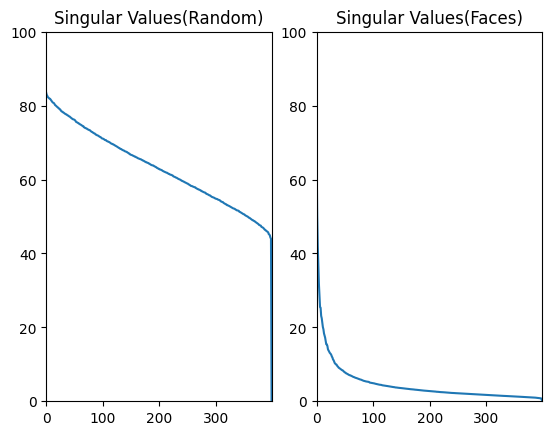

In [37]:
# 얼굴 데이터에 대해 최대 n_components로 PCA 수행하기
pca_faces = PCA(n_components=400, svd_solver="full", whiten=True)
pca_faces.fit(faces_centered)
sv_faces = pca_faces.singular_values_

# 랜덤 데이터에 대해 최대 n_components로 PCA 수행하기
pca_random = PCA(n_components=400, svd_solver="full", whiten=True)
pca_random.fit(random_noises)
sv_random = pca_random.singular_values_


# 각각의 singular value들을 plot해 비교.
plt.subplot(121)
plt.title("Singular Values(Random)")
plt.xlim(0, 399)
plt.ylim(0, 100)
plt.plot(sv_random)

plt.subplot(122)
plt.title("Singular Values(Faces)")
plt.xlim(0, 399)
plt.ylim(0, 100)
plt.plot(sv_faces)

이는 PCA가 수행하는 작업이 결국 샘플, 피쳐 간의 상호 연관성, 즉, 같은 이미지의 다른 부분이나 데이터셋 내의 다른 이미지를 가지고 얼마나 쉽게 이미지의 특정 부분을 추측할 수 있느냐에 따라 달라지게 된다는 것을 의미합니다.

사람의 얼굴 이미지는 서로 많이 다르지만 상당히 많은 유사성을 갖고 있기에 첫 몇 개의 components의 영향을 크게 받는 것이고 그래서 차원축소를 많이 해서 성분의 수를 많이 줄이더라도 원본 이미지가 알아볼 수 있게 복원됩니다.

완전 랜덤으로 생성한 행렬의 경우는 데이터셋의 한 영역으로부터 다른 영역을 복원하는 것이 거의 불가능에 가깝기 때문에, 차원을 줄였을 때 손실되는 정보의 비율이 매우 크고, 차원축소가 거의 동작하지 않는다고 보아도 무방합니다.

실제 현실의 데이터에 PCA를 수행할때는 이런 데이터의 패턴과 예측 가능성을 보고 몇 개 정도의 components를 사용할지 결정하게 됩니다.

## 4. t-SNE(t-distributed Stochastic Neighbor Embedding)를 이용한 데이터셋 시각화

```
💡 목차 개요 : t-SNE(t-distributed Stochastic Neighbor Embedding)를 사용해 고차원 데이터를 2차원에 시각화할 수 있다.
```

- 4-1. 데이터 불러오기
- 4-2. 데이터 시각화



#### 📝 설명: t-SNE(t-distributed Stochastic Neighbor Embedding)

고차원의 데이터를 유의미하게 축소시킨 차원 축소를 이용하여 우리 눈에 이해하기 쉬운 형태로 전달할 수 있습니다. 시각화를 위해 t-SNE (t-distributed Stochastic Neighbor Embedding)을 이용합니다.

예를 들어, 0-9 숫자 이미지 데이터는 1x64x64 차원을 가지고 있습니다. 이미지를 시각화하는 것은 크게 어렵지 않지만, 이 데이터의 행렬 자체를 시각화하는 것은 굉장히 어렵습니다. 우리는 이 숫자 데이터를 구분하기 쉬운 형태로 시각화하고자 할 때 t-SNE와 같은 시각화 방법을 이용합니다.

t-SNE는 데이터 간 유사성을 확률로 변환합니다. 유사성을 이용하면 **고차원 공간에서 비슷한 데이터는 저차원 공간에서 가깝고, 다른 데이터는 서로 멀리 떨어져있도록 학습**합니다. 따라서 서로 유사하고 다른 각 데이터를 '구분'하고자 할 때 많이 사용될 수 있습니다. 위의 숫자 이미지 데이터 예시에서처럼 데이터가 산포된 로컬 구조(좁은 영역)를 기반으로 샘플을 그룹화하여 한 번에 여러 매니폴드로 구성된 데이터들을 시각적으로 분리하는 데 도움이 될 수 있습니다.

데이터를 새로운 다른 낮은 차원으로 변환하면 임베딩(embedding)했다고 하는데, 이 임베딩된(embedded) 공간에서 데이터 간 유사성은 Student t-분포로 표현됩니다. 그리고 원래 공간의 확률 분포와 임베딩된 공간의 KL divergence(두 공간의 결합확률과 임베딩 공간의 확률분포차이)를 줄이도록 학습됩니다.

PCA가 선형부분공간에 투영시키는 방법인데 반해 t-SNE는 비선형적인 부분공간을 찾으므로 복잡한 데이터를 시각화할 때 유용하게 사용될 수 있습니다. t-SNE가 상대적으로 복잡한 구조를 학습하기 때문에 PCA에 비해서 계산량이 많습니다.

###  데이터셋 개요

* 데이터셋: 필기 숫자 데이터셋 (Handwritten Digits)
* 데이터셋 개요 : 필기 숫자 이미지 데이터셋입니다. 총 1,797(학습 1,083)개의 데이터로 이루어져 있으며 데이터, 라벨(타겟), 변수 이름, 타겟 이름으로 구성됩니다.
* 데이터셋 저작권 : CC BY 4.0
* [데이터셋 출처 - UCI](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits)

### 데이터 불러오기

필기 숫자 데이터셋을 불러옵니다.

In [38]:
# 데이터 불러오기
digits = datasets.load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape
print('데이터 수:', n_samples) # 데이터 수 확인
print('차원 수:', n_features) # 차원수 확인

데이터 수: 1083
차원 수: 64


In [39]:
# 첫번째 데이터 확인하기
X[[0]]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
        15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
        12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
         0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
        10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

숫자 데이터는 64개의 차원을 가지고 있습니다. 위에서 확인할 수 있듯이 이 64개의 차원을 가진 데이터의 각 값을 한눈에 확인하고 비교하는 것은 어렵습니다. 따라서 우리는 데이터를 시각화하여 각 데이터를 2차원에 한눈에 이해하기 쉽도록 만들고자 합니다.

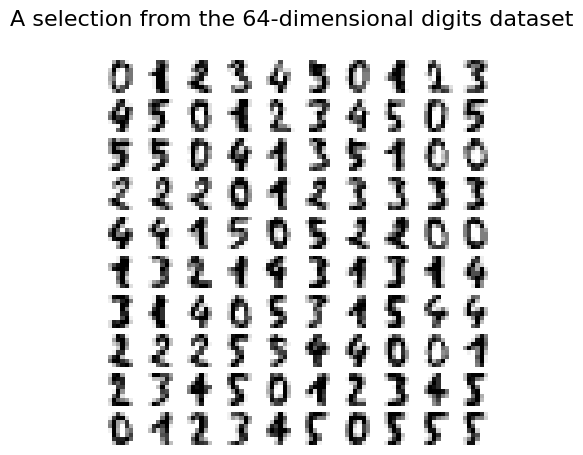

In [40]:
# 숫자 이미지 시각화
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(5, 5))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

#### 👨‍💻 코드: plot을 도와주는 함수 정의

In [41]:
# plot helper 함수 정의
def plot_embedding(X, title):
    _, ax = plt.subplots()
    # 정규화
    X = MinMaxScaler().fit_transform(X)
    # 색깔로 숫자로 scatter 표시
    for digit in digits.target_names:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=2,
        )
    # 이미지 그림 표시
    shown_images = np.array([[1.0, 1.0]])
    for i in range(X.shape[0]):
        # 모든 숫자 임베딩을 scatter하고, 숫자 그룹에 annotation box를 보기
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        # 보기 쉽게 하기 위해 너무 가까운 데이터는 보여주지 않기
        if np.min(dist) < 4e-3:
            continue
        # 이미지 합치기
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

t-SNE를 이용하여 높은 차원의 숫자 데이터를 2차원에 시각화합니다.

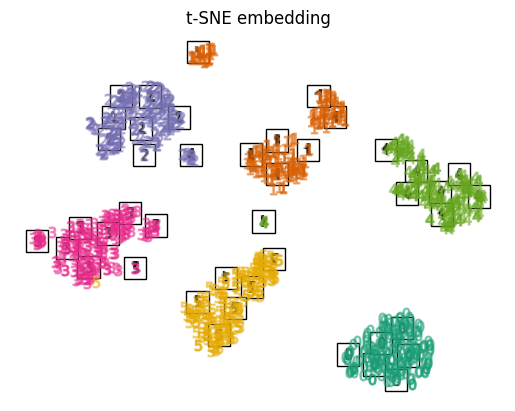

In [42]:
# t-SNE 적용
transformer = TSNE(n_components=2, random_state=0)
projection = transformer.fit_transform(X, y)

# t-SNE 결과 시각화
plot_embedding(projection, 't-SNE embedding')
plt.show()

위 시각화 그림을 보면, 각 데이터가 숫자 클래스에 의해서 구분된 것을 확인할 수 있는데, 데이터의 패턴을 잘 학습한 embedding 공간을 찾아 시각화하여 이 2차원 공간만으로도 데이터가 서로 비슷하고 다른 특징을 잘 찾았다는 것을 의미합니다. 이로부터 분류 모델 등을 이용하지 않고도 데이터의 구분되는 특징을 파악할 수 있습니다.

위에서 살펴본 Truncated SVD를 적용한 것과 비교해봅니다.

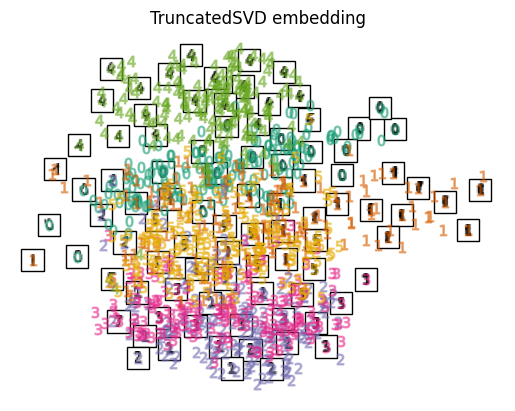

In [43]:
# Truncated SVD 적용
transformer = TruncatedSVD(n_components=2)
projection = transformer.fit_transform(X, y)

# TruncatedSVD 결과 시각화
plot_embedding(projection, 'TruncatedSVD embedding')
plt.show()

Truncated SVD 시각화로부터 데이터들이 어느정도 구분은 할 수 있으나 클래스 별 거리가 잘 보이지 않는 것을 확인할 수 있습니다. 이처럼 T-SNE는 클래스 별 구분을 명확하게 하는 데에 강점을 가진 것을 확인할 수 있습니다.